In [2]:
import pandas_datareader.data as web
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV as RCV
import matplotlib.pyplot as plt

In [19]:
df = web.DataReader('SPY',data_source='yahoo',start='2010')

In [20]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002,95.218681,90637900
2010-01-04,112.370003,113.389999,111.510002,113.330002,96.833588,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,97.089912,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,97.158264,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,97.568398,131091100


In [21]:
df = df[['Open','High','Low','Close']]

In [22]:
df.head()

,Open,High,Low,Close
Date,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002
2010-01-04,112.370003,113.389999,111.510002,113.330002
2010-01-05,113.260002,113.680000,112.849998,113.629997
2010-01-06,113.519997,113.989998,113.430000,113.709999
2010-01-07,113.500000,114.330002,113.180000,114.190002


In [23]:
df['OpenShifted'] = df['Open'].shift(1)
df['HighShifted'] = df['High'].shift(1)
df['LowShifted'] = df['Low'].shift(1)
df['CloseShifted'] = df['Close'].shift(1)

In [24]:
df.head()

,Open,High,Low,Close,OpenShifted,HighShifted,LowShifted,CloseShifted
Date,,,,,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002,NaN,NaN,NaN,NaN
2010-01-04,112.370003,113.389999,111.510002,113.330002,112.769997,112.800003,111.389999,111.440002
2010-01-05,113.260002,113.680000,112.849998,113.629997,112.370003,113.389999,111.510002,113.330002
2010-01-06,113.519997,113.989998,113.430000,113.709999,113.260002,113.680000,112.849998,113.629997
2010-01-07,113.500000,114.330002,113.180000,114.190002,113.519997,113.989998,113.430000,113.709999


In [25]:
df.tail()

,Open,High,Low,Close,OpenShifted,HighShifted,LowShifted,CloseShifted
Date,,,,,,,,
2017-12-04,266.309998,266.799988,264.079987,264.140015,264.760010,265.309998,260.760010,264.459991
2017-12-05,263.190002,265.149994,263.040009,263.190002,266.309998,266.799988,264.079987,264.140015
2017-12-06,263.299988,263.730011,262.709991,263.239990,263.190002,265.149994,263.040009,263.190002
2017-12-07,264.070007,264.429993,262.940002,264.070007,263.299988,263.730011,262.709991,263.239990
2017-12-08,265.160004,265.519989,264.029999,265.510010,264.070007,264.429993,262.940002,264.070007


In [26]:
imp = Imputer(missing_values='NaN', strategy='mean',axis=0)

In [30]:
steps = [('imputation', imp),
        ('scaler',StandardScaler()),
        ('lasso',Lasso())]

In [31]:
pipline = Pipeline(steps)

In [32]:
params = {'lasso__alpha':np.arange(0.0001,10,0.0001),
         'lasso__max_iter':np.random.uniform(100,100000,4)}

In [33]:
# Applies Cross-Validation cv times 
reg = RCV(pipline,params,cv=5)

In [38]:
X = df[ ['OpenShifted','HighShifted','LowShifted','CloseShifted'] ]
y = df['Close']

In [40]:
avg_err = {}

In [45]:
for i in np.arange(50,95,3):
    split = int(i*len(X)/100)
    reg.fit(X[:split], y[:split])
    best_alpha = reg.best_params_['lasso__alpha']
    best_iter = reg.best_params_['lasso__max_iter']
    reg1 = Lasso(alpha=best_alpha, max_iter = best_iter)
    X = imp.fit_transform(X,y)
    reg1.fit(X[:split], y[:split])
    df['P_C_%i'%i]= 0.0
    
    df.iloc[split:, df.columns.get_loc('P_C_%i'%i)] = reg1.predict(X[split:])
    df['Error_%i'%i] = np.abs(df['P_C_%i'%i] - df['Close'])
    e = np.mean(df['Error_%i'%i][split:])
    avg_err[i] = e

In [47]:
df.head()

,Open,High,Low,Close,OpenShifted,HighShifted,LowShifted,CloseShifted,P_C_50,Error_50,...,P_C_80,Error_80,P_C_83,Error_83,P_C_86,Error_86,P_C_89,Error_89,P_C_92,Error_92
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002,NaN,NaN,NaN,NaN,0.0,111.440002,...,0.0,111.440002,0.0,111.440002,0.0,111.440002,0.0,111.440002,0.0,111.440002
2010-01-04,112.370003,113.389999,111.510002,113.330002,112.769997,112.800003,111.389999,111.440002,0.0,113.330002,...,0.0,113.330002,0.0,113.330002,0.0,113.330002,0.0,113.330002,0.0,113.330002
2010-01-05,113.260002,113.680000,112.849998,113.629997,112.370003,113.389999,111.510002,113.330002,0.0,113.629997,...,0.0,113.629997,0.0,113.629997,0.0,113.629997,0.0,113.629997,0.0,113.629997
2010-01-06,113.519997,113.989998,113.430000,113.709999,113.260002,113.680000,112.849998,113.629997,0.0,113.709999,...,0.0,113.709999,0.0,113.709999,0.0,113.709999,0.0,113.709999,0.0,113.709999
2010-01-07,113.500000,114.330002,113.180000,114.190002,113.519997,113.989998,113.430000,113.709999,0.0,114.190002,...,0.0,114.190002,0.0,114.190002,0.0,114.190002,0.0,114.190002,0.0,114.190002


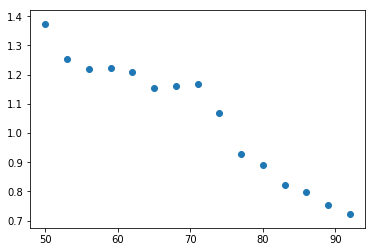

In [49]:
Range = df['HighShifted'][split:] - df['LowShifted'][split:]
plt.scatter(avg_err.keys(), avg_err.values())
plt.show()